In [20]:
import pandas as pd
import numpy as np
from keras import losses, models, optimizers
from keras.layers import (Input, Dense, Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, GlobalMaxPool2D, MaxPool2D, concatenate, Activation)
from keras.utils import Sequence, to_categorical
from keras import backend as K
from keras.callbacks import (EarlyStopping, ModelCheckpoint, TensorBoard)
from keras.activations import relu, softmax
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold

import librosa
import os
import shutil
import warnings

%matplotlib inline
matplotlib.style.use('ggplot')

warnings.filterwarnings("ignore", category=FutureWarning) 

In [2]:
# Change this to True for full dataset and learning
COMPLETE_RUN = True
data_path = '../data'

In [3]:
train = pd.read_csv(data_path + "/train_noisy.csv")
test = pd.read_csv(data_path + "/sample_submission.csv")

In [4]:
train.sample(5)

,fname,labels
5666,48e69acd.wav,Walk_and_footsteps
12567,a1bdd35e.wav,Clapping
7812,64f28637.wav,Bass_guitar
2622,21e10e65.wav,Cricket
16383,d4000e20.wav,Meow


In [8]:
print(len(train))

19815


In [9]:
train = train[train['labels'].isin(test.columns[1:])]
print(len(train))

16566


In [10]:
category_group = train.groupby(['labels']).count()
category_group.columns = ['counts']
print(len(category_group))

80


In [11]:
category_group.sample(5)

,counts
labels,
Bicycle_bell,221
Strum,100
Water_tap_and_faucet,28
Toilet_flush,135
Acoustic_guitar,249


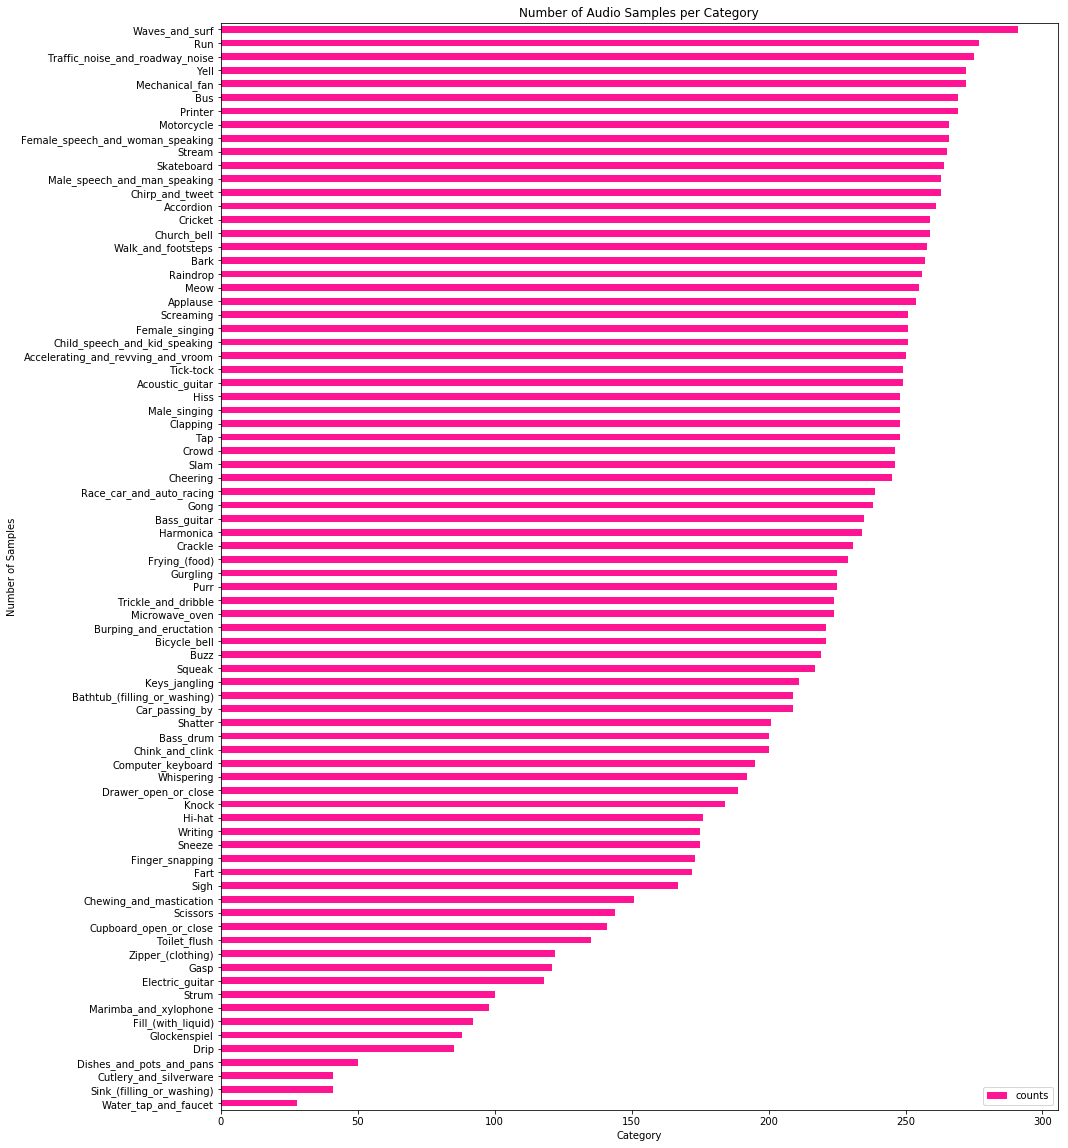

In [13]:
plot = category_group.sort_values(ascending=True, by='counts').plot(
    kind='barh', 
    title="Number of Audio Samples per Category", 
    color='deeppink', 
    figsize=(15,20))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");

In [14]:
print('Minimum samples per category = ', min(train['labels'].value_counts()))
print('Maximum samples per category = ', max(train['labels'].value_counts()))

Minimum samples per category =  28
Maximum samples per category =  291


In [16]:
import IPython.display as ipd  # To play sound in the notebook
fname = data_path + '/train_noisy/64f28637.wav'   # bass guitar
ipd.Audio(fname)

In [17]:
# Using wave library
import wave

wav = wave.open(fname)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  661500
Duration =  15.0


In [18]:
# Using scipy
from scipy.io import wavfile
rate, data = wavfile.read(fname)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (661500,)
[  4180   4270   4440 ... -15306 -15239 -15043]


In [36]:
max(data)

29623

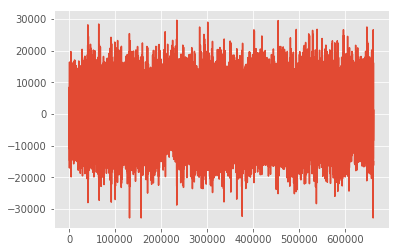

In [21]:
plt.plot(data, '-', );

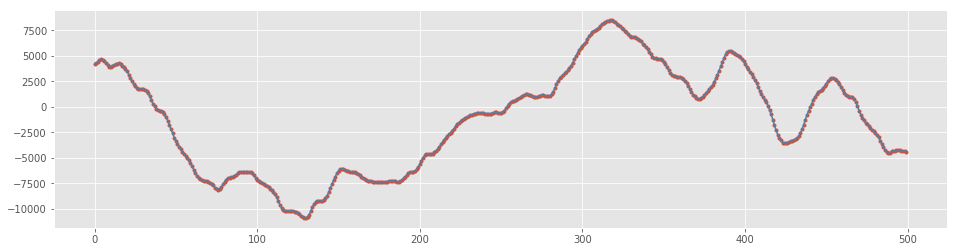

In [22]:
# Let's zoom in on first 1000 frames
plt.figure(figsize=(16, 4))
plt.plot(data[:500], '.'); plt.plot(data[:500], '-');

In [25]:
train['nframes'] = train['fname'].apply(lambda f: wave.open(data_path + '/train_noisy/' + f).getnframes())
test['nframes'] = test['fname'].apply(lambda f: wave.open(data_path + '/test/' + f).getnframes())

In [27]:
train.sample(5)

,fname,labels,nframes
530,0713b5e3.wav,Crowd,661500
3078,276c87d3.wav,Finger_snapping,661500
11099,8f323275.wav,Motorcycle,661500
14193,b673ae54.wav,Bicycle_bell,661500
12231,9d303751.wav,Race_car_and_auto_racing,661500


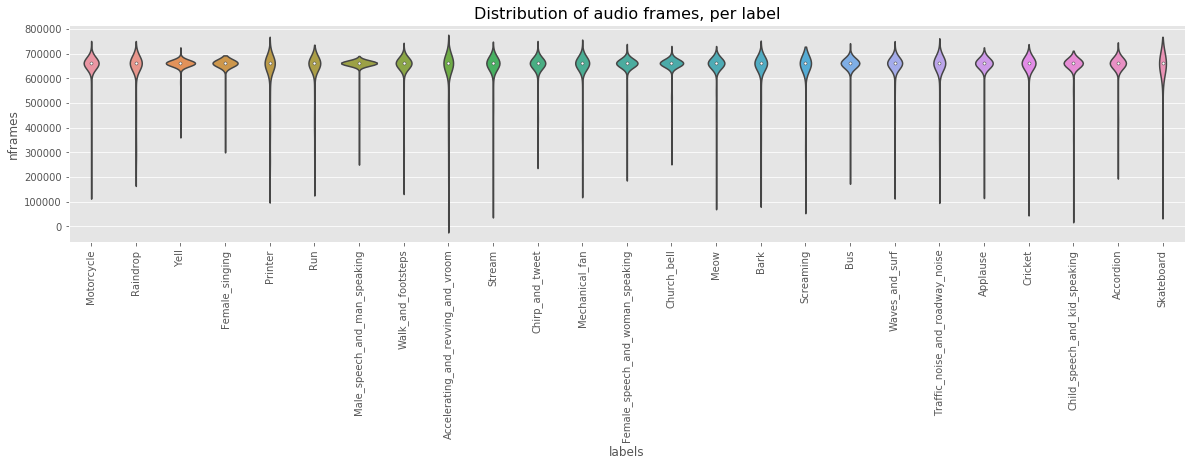

In [28]:
# The number of categories is large, so let's check the frame distributions of top 25 categories.

idx_sel = category_group.sort_values(ascending=True, by='counts').index[-25:]
_, ax = plt.subplots(figsize=(20, 4))
sns.violinplot(ax=ax, x="labels", y="nframes", data=train[(train['labels'].isin(idx_sel).values)])
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

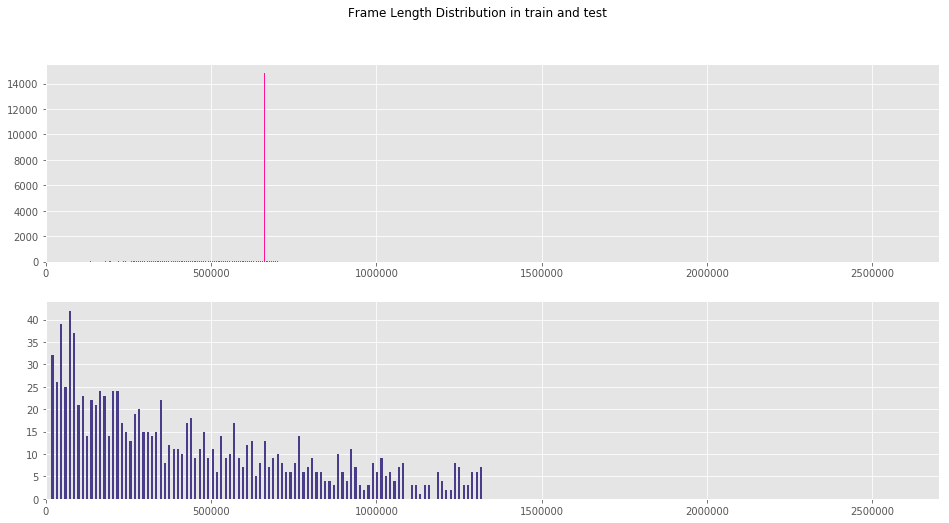

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(16,8))
train.nframes.hist(bins=100, grid=True, rwidth=0.5, ax=ax[0], color='deeppink')
test.nframes.hist(bins=100, grid=True, rwidth=0.5, ax=ax[1], color='darkslateblue')
ax[0].set_xlim(0, 2700000)
ax[1].set_xlim(0, 2700000)
plt.suptitle('Frame Length Distribution in train and test', ha='center', fontsize='large');

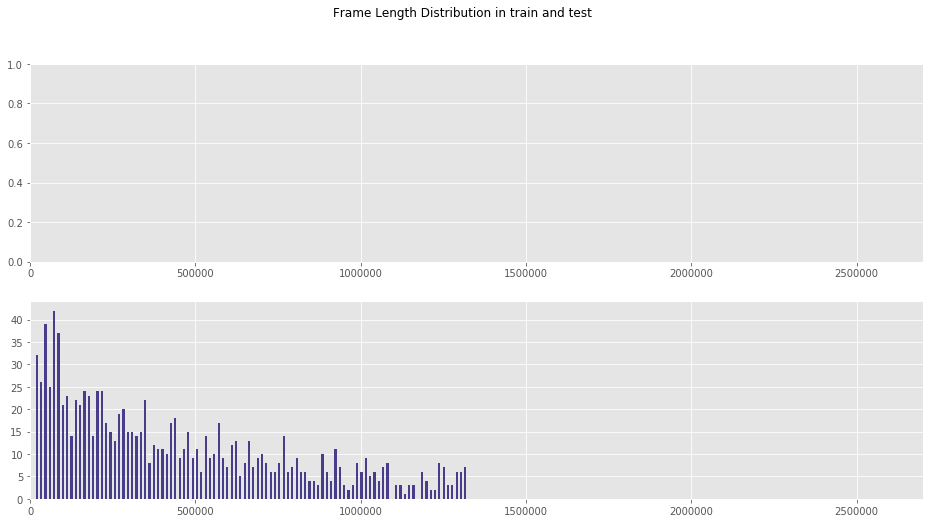

In [55]:
fig, ax = plt.subplots(2, 1, figsize=(16,8))
test.nframes.hist(bins=100, grid=True, rwidth=0.5, ax=ax[1], color='darkslateblue')
ax[0].set_xlim(0, 2700000)
ax[1].set_xlim(0, 2700000)
plt.suptitle('Frame Length Distribution in train and test', ha='center', fontsize='large');

In [35]:
train.sample(10)

,fname,labels,nframes
17898,e6c2f84f.wav,Applause,661500
4021,33584207.wav,Slam,661500
8632,6edd0d7d.wav,Drawer_open_or_close,661500
14817,be79daff.wav,Microwave_oven,661500
8769,70d0fb18.wav,Slam,661500
17120,dd4e7c48.wav,Bark,661500
6961,5975f012.wav,Trickle_and_dribble,661500
2284,1d99f153.wav,Yell,661500
13099,a8140b45.wav,Purr,661500
13088,a7e0cb2c.wav,Chink_and_clink,661500


In [5]:
print("Number of train examples=", train.shape[0], "  Number of classes=", len(set(train['labels'])))
print("Number of test examples=", test.shape[0], "  Number of classes=", len(set(test.columns[1:])))

Number of train examples= 19815   Number of classes= 1168
Number of test examples= 1120   Number of classes= 80


In [6]:
test.columns

Index(['fname', 'Accelerating_and_revving_and_vroom', 'Accordion',
       'Acoustic_guitar', 'Applause', 'Bark', 'Bass_drum', 'Bass_guitar',
       'Bathtub_(filling_or_washing)', 'Bicycle_bell',
       'Burping_and_eructation', 'Bus', 'Buzz', 'Car_passing_by', 'Cheering',
       'Chewing_and_mastication', 'Child_speech_and_kid_speaking',
       'Chink_and_clink', 'Chirp_and_tweet', 'Church_bell', 'Clapping',
       'Computer_keyboard', 'Crackle', 'Cricket', 'Crowd',
       'Cupboard_open_or_close', 'Cutlery_and_silverware',
       'Dishes_and_pots_and_pans', 'Drawer_open_or_close', 'Drip',
       'Electric_guitar', 'Fart', 'Female_singing',
       'Female_speech_and_woman_speaking', 'Fill_(with_liquid)',
       'Finger_snapping', 'Frying_(food)', 'Gasp', 'Glockenspiel', 'Gong',
       'Gurgling', 'Harmonica', 'Hi-hat', 'Hiss', 'Keys_jangling', 'Knock',
       'Male_singing', 'Male_speech_and_man_speaking', 'Marimba_and_xylophone',
       'Mechanical_fan', 'Meow', 'Microwave_oven', 'Mo

In [7]:
np.set_printoptions(threshold=1168)
train['labels'].unique()

array(['Bathtub_(filling_or_washing)', 'Motorcycle',
       'Marimba_and_xylophone,Glockenspiel',
       'Water_tap_and_faucet,Sink_(filling_or_washing)', 'Raindrop',
       'Bass_guitar', 'Raindrop,Trickle_and_dribble',
       'Strum,Acoustic_guitar', 'Bass_drum,Hi-hat', 'Harmonica', 'Slam',
       'Scissors', 'Cheering,Crowd', 'Crackle', 'Purr', 'Crowd', 'Yell',
       'Female_singing', 'Printer', 'Finger_snapping', 'Microwave_oven',
       'Hi-hat', 'Run', 'Bass_drum', 'Squeak', 'Acoustic_guitar',
       'Male_speech_and_man_speaking', 'Tap', 'Microwave_oven,Buzz',
       'Water_tap_and_faucet,Frying_(food)', 'Fart',
       'Race_car_and_auto_racing', 'Frying_(food)',
       'Motorcycle,Microwave_oven', 'Walk_and_footsteps', 'Buzz',
       'Accelerating_and_revving_and_vroom', 'Stream', 'Male_singing',
       'Chirp_and_tweet', 'Clapping', 'Mechanical_fan',
       'Frying_(food),Dishes_and_pots_and_pans,Cutlery_and_silverware',
       'Mechanical_fan,Buzz', 'Female_speech_and_woman_

In [8]:
# Same as with the curated set, we'll ignore multi labeled rows for now.
# Unlike the curated set though this will drastically cut down a large portion of the data set
train = train[train['labels'].isin(test.columns[1:])]
print(len(train))

16566


In [9]:
len(set(train['labels'])) # But now we're working with less than 7% of the original number of labels that describes more 83% of all the clips

80

In [10]:
test.sample(1)

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
1018,3c35237b.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
category_group = train.groupby(['labels']).count()
category_group.columns = ['counts']
print(len(category_group))

80


In [12]:
# The Configuration object stores those learning parameters that are shared
# between data generators models, and training functions. Anything that is
# global as far as the training is concerned can become the part of Configuration object.

class Config(object):
    def __init__(self,
                 sampling_rate=16000,
                 audio_duration=2, 
                 n_classes=len(category_group),
                 use_mfcc=False,
                 n_folds=10,
                 learning_rate=0.0001, 
                 max_epochs=50,
                 n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

In [13]:
# The DataGenerator class inherits from keras.utils.Sequence .
# It is useful for preprocessing and feeding the data to a Keras model.

# Note: Sequence are a safer way to do multiprocessing.
# This structure guarantees that the network will only train once on each
# sample per epoch which is not the case with generators.

class DataGenerator(Sequence):
    def __init__(self,
                 config,
                 data_dir,
                 list_IDs,
                 labels=None, 
                 batch_size=64,
                 preprocessing_fn=lambda x: x):
        self.config = config
        self.data_dir = data_dir
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.preprocessing_fn = preprocessing_fn
        self.on_epoch_end()
        self.dim = self.config.dim

    def __len__(self):
        # Once initialized with a batch_size, DataGenerator computes the number of batches in an epoch.
        # The __len__ method tells Keras how many batches to draw in each epoch.
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # The __getitem__ method takes an index (which is the batch number) and
        # returns a batch of the data (both X and y) after calculating the offset.
        # During test time, only X is returned.
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        return self.__data_generation(list_IDs_temp)

    def on_epoch_end(self):
        # If we want to perform some action after each epoch (like shuffle the data,
        # or increase the proportion of augmented data), we can use the on_epoch_end method.
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.dim))

        input_length = self.config.audio_length
        for i, ID in enumerate(list_IDs_temp):
            file_path = self.data_dir + ID
            
            # Read and Resample the audio
            data, _ = librosa.core.load(file_path, sr=self.config.sampling_rate, res_type='kaiser_fast')

            # Random offset / Padding
            if len(data) > input_length:
                max_offset = len(data) - input_length
                offset = np.random.randint(max_offset)
                data = data[offset:(input_length+offset)]
            else:
                if input_length > len(data):
                    max_offset = input_length - len(data)
                    offset = np.random.randint(max_offset)
                else:
                    offset = 0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
                
            # Normalization + Other Preprocessing
            if self.config.use_mfcc:
                data = librosa.feature.mfcc(data, sr=self.config.sampling_rate, n_mfcc=self.config.n_mfcc)
                data = np.expand_dims(data, axis=-1)
            else:
                data = self.preprocessing_fn(data)[:, np.newaxis]
            X[i,] = data

        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            return X, to_categorical(y, num_classes=self.config.n_classes)
        else:
            return X

In [14]:
def get_2d_dummy_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = GlobalMaxPool2D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model


def get_2d_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [15]:
# It is important to convert raw labels to integer indices
train.head()

,fname,labels
0,00097e21.wav,Bathtub_(filling_or_washing)
1,000b6cfb.wav,Motorcycle
4,0019adae.wav,Raindrop
5,001b819d.wav,Bass_guitar
9,0020becb.wav,Harmonica


In [16]:
LABELS = list(train['labels'].unique())
label_idx = {label: i for i, label in enumerate(LABELS)}

train.set_index("fname", inplace=True)
test.set_index("fname", inplace=True)

train["label_idx"] = train['labels'].apply(lambda x: label_idx[x])

if not COMPLETE_RUN:
    train = train[:2000]
    test = test[:2000]

In [17]:
# raw labels with integer indices
train.head()

,labels,label_idx
fname,,
00097e21.wav,Bathtub_(filling_or_washing),0
000b6cfb.wav,Motorcycle,1
0019adae.wav,Raindrop,2
001b819d.wav,Bass_guitar,3
0020becb.wav,Harmonica,4


In [18]:
config = Config(sampling_rate=44100, audio_duration=2, n_folds=10, 
                learning_rate=0.001, use_mfcc=True, n_mfcc=40)
if not COMPLETE_RUN:
    config = Config(sampling_rate=44100, audio_duration=2, n_folds=2, 
                    max_epochs=1, use_mfcc=True, n_mfcc=40)

In [19]:
def prepare_data(df, config, data_dir):
    X = np.empty(shape=(df.shape[0], config.dim[0], config.dim[1], 1))
    input_length = config.audio_length
    for i, fname in enumerate(df.index):
        file_path = data_dir + fname
        data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
    return X

In [20]:
%time
X_train_noisy = prepare_data(train, config, data_path + '/train_noisy/')
X_test = prepare_data(test, config, data_path + '/test/')
y_train = to_categorical(train.label_idx.astype('str'), num_classes=config.n_classes)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


In [21]:
# Normalize data
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [22]:
# Training 2D Conv on MFCC

PREDICTION_FOLDER = "predictions_2d_conv"
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

skf = StratifiedKFold(n_splits=config.n_folds)

for i, (train_split, val_split) in enumerate(skf.split(train.index, train.label_idx)):
    K.clear_session()
    X, y, X_val, y_val = X_train[train_split], y_train[train_split], X_train[val_split], y_train[val_split]
    checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%i'%i, write_graph=True)
    callbacks_list = [checkpoint, early, tb]
    print("#"*50)
    print("Fold: ", i)
    model = get_2d_conv_model(config)
    history = model.fit(X, y, validation_data=(X_val, y_val), callbacks=callbacks_list, 
                        batch_size=64, epochs=config.max_epochs)
    model.load_weights('best_%d.h5'%i)

    # Save train predictions
    predictions = model.predict(X_train, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)

    # Save test predictions
    predictions = model.predict(X_test, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)

    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)

##################################################
Fold:  0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 14872 samples, validate on 1694 samples
Epoch 1/50
14872/14872 [==============================] - 415s 28ms/step - loss: 3.9441 - acc: 0.0908 - val_loss: 3.8106 - val_acc: 0.0998

Epoch 00001: val_loss improved from inf to 3.81063, saving model to best_0.h5
Epoch 2/50
14872/14872 [==============================] - 412s 28ms/step - loss: 3.3780 - acc: 0.1776 - val_loss: 3.5646 - val_acc: 0.1228

Epoch 00002: val_loss improved from 3.81063 to 3.56456, saving model to best_0.h5
Epoch 3/50
14872/14872 [==============================] - 411s 28ms/step - loss: 3.1410 - acc: 0.2173 - val_loss: 3.3645 - val_acc: 0.1730

Epoch 00003: val_loss improved from 3.56456 to 3.36451, saving model to best_0.h5
Epoch 4/50
14872/14872 [==============================] - 411s 28ms/step - loss: 2.9738 - acc: 0.2489 - val_l

14893/14893 [==============================] - 401s 27ms/step - loss: 1.9424 - acc: 0.4848 - val_loss: 3.3531 - val_acc: 0.2307

Epoch 00012: val_loss did not improve from 3.14119
Epoch 13/50
14893/14893 [==============================] - 401s 27ms/step - loss: 1.7834 - acc: 0.5245 - val_loss: 3.6345 - val_acc: 0.2008

Epoch 00013: val_loss did not improve from 3.14119
Epoch 14/50
14893/14893 [==============================] - 401s 27ms/step - loss: 1.6230 - acc: 0.5647 - val_loss: 3.7712 - val_acc: 0.2068

Epoch 00014: val_loss did not improve from 3.14119
1120/1120 [==============================] - 8s 7ms/step
##################################################
Fold:  3
Train on 14896 samples, validate on 1670 samples
Epoch 1/50
14896/14896 [==============================] - 402s 27ms/step - loss: 3.9033 - acc: 0.0981 - val_loss: 3.7035 - val_acc: 0.1108

Epoch 00001: val_loss improved from inf to 3.70351, saving model to best_3.h5
Epoch 2/50
14896/14896 [============================

OSError: Unable to create file (file write failed: time = Mon May 13 20:58:43 2019
, filename = 'best_4.h5', file descriptor = 47, errno = 28, error message = 'No space left on device', buf = 0x55b0f39926c0, total write size = 96, bytes this sub-write = 96, bytes actually written = 18446744073709551615, offset = 0)

In [ ]:
# Ensembling 2D Conv Predictions¶

pred_list = []
for i in range(config.n_folds):
    pred_list.append(np.load("./predictions_2d_conv/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv(data_path + '/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("2d_conv_ensembled_noisy_submission.csv", index=False)

4

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.
